## Modelling

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("cleaned_data.csv")
df.head()

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998"
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002"
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005"


In [4]:
!! pip install scikit-learn

['Requirement already satisfied: scikit-learn in c:\\users\\hp\\documents\\anaconda\\lib\\site-packages (1.1.3)',
 'Requirement already satisfied: scipy>=1.3.2 in c:\\users\\hp\\documents\\anaconda\\lib\\site-packages (from scikit-learn) (1.7.3)',
 'Requirement already satisfied: joblib>=1.0.0 in c:\\users\\hp\\documents\\anaconda\\lib\\site-packages (from scikit-learn) (1.1.0)',
 'Requirement already satisfied: numpy>=1.17.3 in c:\\users\\hp\\documents\\anaconda\\lib\\site-packages (from scikit-learn) (1.21.5)',
 'Requirement already satisfied: threadpoolctl>=2.0.0 in c:\\users\\hp\\documents\\anaconda\\lib\\site-packages (from scikit-learn) (2.2.0)']

In [5]:
df['Synopsis'].isnull().sum()

0

In [6]:
df['Synopsis'] = df['Synopsis'].fillna('')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(df['Synopsis'])

tfidf_matrix.shape

(12979, 40034)

In [8]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.23529586, 0.02127464, ..., 0.02133734, 0.00457067,
        0.02050118],
       [0.23529586, 1.        , 0.04320112, ..., 0.01628467, 0.01529336,
        0.        ],
       [0.02127464, 0.04320112, 1.        , ..., 0.00264197, 0.        ,
        0.        ],
       ...,
       [0.02133734, 0.01628467, 0.00264197, ..., 1.        , 0.        ,
        0.        ],
       [0.00457067, 0.01529336, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.02050118, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [9]:
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()
indices

Title
Cowboy Bebop                            0
Cowboy Bebop Tengoku no Tobira          1
Trigun                                  2
Witch Hunter Robin                      3
Bouken Ou Beet                          4
                                    ...  
Animagear                           12974
Magical Halloween MiracleQuartet    12975
Orbital Era                         12976
Akai Hana Shiroi Hana               12977
Arui Tekoteko                       12978
Length: 12979, dtype: int64

In [10]:
def get_recommendations(title, cosine_sim=cosine_sim):
    
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 15 most similar movies
    sim_scores = sim_scores[1:16]
    
    anime_indices = [i[0] for i in sim_scores]

    return df['Title'].iloc[anime_indices]

In [11]:
get_recommendations('Sen to Chihiro no Kamikakushi')

9604                                      Shounen Maid
560                                 Kujibiki Unbalance
4521                               Suki Desu Suzukikun
5520             Kami nomi zo Shiru Sekai 4nin to Idol
3283                       KerakuNoOH King of Pleasure
10156                              Kushimitama Samurai
5869                                      Sankarea OVA
2422                             ef A Tale of Memories
2816                                         Kiss yori
4199              ef A Tale of Memories  Recollections
11903                                   Mirai no Mirai
740                                         Jyu Oh Sei
2669                                    Hatenkou Yuugi
4822     Ultraman Kids Haha wo Tazunete 3000man Kounen
5113                                Koguma no Korochan
Name: Title, dtype: object

In [12]:
get_recommendations('Koe no Katachi')

12407    Seishun Buta Yarou wa Yumemiru Shoujo no Yume ...
1254                                      Asatte no Houkou
5605                                          Hero Herokun
9159                                     Yuujou no Kickoff
1731                                                  Pops
6486                                          Danchi Tomoo
4730                        Fortune Arterial Akai Yakusoku
12702                               Tomo Tabidachi no Toki
6611                         Kakumeiki Valvrave 2nd Season
6473                                        Harisu no Kaze
8974                         Gakuen Handsome The Animation
10173                                      Gakuen Handsome
10787                                           Tejina Shi
5429                                    VitaminX Addiction
5830                             Yajikita Gakuen Douchuuki
Name: Title, dtype: object

Genres, Producer and Studio Based Recommender It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the producer, related genres and the studio.

In [13]:
df.head(2)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"


In [14]:
features = ['Genre','Producer', 'Studio']

print(df[features].isnull().sum())

Genre          0
Producer    5779
Studio      5611
dtype: int64


In [15]:
df[features] = df[features].fillna('[' ']')

In [16]:
from ast import literal_eval

for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [17]:
df.Type.unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', 'Unknown'],
      dtype=object)

In [18]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ","")) for i in x]
    
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ",""))
        else:
            return ""

In [19]:
features = ['Genre','Producer', 'Studio', 'Type']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [20]:
df.head(2)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"[action, adventure, comedy, drama, sci-fi, space]","In the year 2071, humanity has colonized sever...",tv,[bandaivisual],[sunrise],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"[action, space, drama, mystery, sci-fi]","Another day, another bounty—such is the life o...",movie,"[sunrise, bandaivisual]",[bones],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"


In [21]:
features

['Genre', 'Producer', 'Studio', 'Type']

In [22]:
def create_soup(x):
    return " ".join(x['Genre']) + " " + x['Type'] + " " + " ".join(x['Producer']) + " " + " ".join(x['Studio']) + " " + x['Synopsis'] + " " + " ".join(x['Studio']) 

In [23]:
df['soup'] = df.apply(create_soup, axis=1)

In [24]:
df['soup']

0        action adventure comedy drama sci-fi space tv ...
1        action space drama mystery sci-fi movie sunris...
2        action sci-fi adventure comedy drama shounen t...
3        action magic police supernatural drama mystery...
4        adventure fantasy shounen supernatural tv  toe...
                               ...                        
12974    kids mecha ona   A promotional video for the n...
12975    comedy ecchi fantasy game music music   Bundle...
12976    action adventure fantasy sci-fi space movie   ...
12977    kids music music   Akai Hana Shiroi Hana  was ...
12978    kids music music   Of a pair of shoes, the lef...
Name: soup, Length: 12979, dtype: object

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an producer if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [26]:
df = df.reset_index()
indices = pd.Series(df.index, index=df['Title'])

In [27]:
indices

Title
Cowboy Bebop                            0
Cowboy Bebop Tengoku no Tobira          1
Trigun                                  2
Witch Hunter Robin                      3
Bouken Ou Beet                          4
                                    ...  
Animagear                           12974
Magical Halloween MiracleQuartet    12975
Orbital Era                         12976
Akai Hana Shiroi Hana               12977
Arui Tekoteko                       12978
Length: 12979, dtype: int64

In [28]:
get_recommendations('Cowboy Bebop', cosine_sim2)

1                           Cowboy Bebop Tengoku no Tobira
5488                                Planetes Picture Drama
2268          Ginga Tetsudou Monogatari Eien e no Bunkiten
4970                  Shin Mashin Eiyuuden Wataru Majinzan
3226                                  Ginga Senpuu Braiger
4089                   Sora wo Kakeru Shoujo Picture Drama
979                              Seihou Tenshi Angel Links
7542     Seihou Tenshi Angel Links Meifon no Special Ka...
6253       Mashin Eiyuuden Wataru Soukaizan Eiyuu Densetsu
10632            Mobile Suit Gundam Thunderbolt 2nd Season
6718                                  Dagram vs RoundFacer
1473               Dirty Pair no Ooshoubu Nolandia no Nazo
3836                                     Space Cobra Pilot
4428                    Wrestler Gundan Seisenshi Robin Jr
5017                         Zero Tester Chikyuu wo Mamore
Name: Title, dtype: object

In [29]:
get_recommendations('Sen to Chihiro no Kamikakushi', cosine_sim2)

740                                           Jyu Oh Sei
11903                                     Mirai no Mirai
9604                                        Shounen Maid
10156                                Kushimitama Samurai
4534                             Karigurashi no Arrietty
2669                                      Hatenkou Yuugi
7374     Kero Kero Keroppi no Yowamushiouji no Daibouken
9583                                     Kemushi no Boro
6438           Ashita Genki ni Nare Hanbun no Satsumaimo
5299                                Da Yu Hai Tang Movie
6115                      Majokko Shimai no Yoyo to Nene
999               Fushigi no Umi no Nadia Original Movie
6381                                                 Jib
5113                                  Koguma no Korochan
3124                                    Net Ghost Pipopa
Name: Title, dtype: object

In [30]:
get_recommendations('Mirai no Mirai', cosine_sim2)

3478                             Umineko no Naku Koro ni
3809                                   Suteneko Torachan
2269                                       Umi no Triton
4233                           Doubutsu Mura no Daisodou
9493                    Tenchi Muyou Ryououki 4th Season
11288                                        Yao Shen Ji
5123                                               Oshin
8323     Kyoukai no Kanata Movie 2 Ill Be Here  Miraihen
6529                                         Golden Time
6035                           Kono Sekai no Katasumi ni
298                            Mama wa Shougaku 4 Nensei
5766                        Ookami Kodomo no Ame to Yuki
8395                                           Hand Soap
6357                                 Dareka no Manazashi
1498                                      Hadashi no Gen
Name: Title, dtype: object

In [31]:
display(df[['Title', 'Rating', 'Producer', 'Studio']].loc[df['Title'] == 'Sen to Chihiro no Kamikakushi'])

,Title,Rating,Producer,Studio
178,Sen to Chihiro no Kamikakushi,8.92,[toho],[studioghibli]


####   Model 2

In [48]:
# importing some libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
import warnings
warnings.filterwarnings('ignore')

In [49]:
cleaned_data=pd.read_csv('cleaned_data.csv')

In [50]:
cleaned_data.head()

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001"
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998"
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002"
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005"


In [51]:
import sys
print(sys.executable)

C:\Users\hp\Documents\anaconda\python.exe


In [52]:
# renaming the anime_id col
cleaned_data=cleaned_data.rename(columns={'MAL_ID':'anime_id'})

In [53]:
#looking at the shape
cleaned_data.shape

(12979, 14)

In [54]:
#loading the ratings data
rating=pd.read_csv('rating.csv')

In [55]:
# checking for duplicates
duplicates=rating.duplicated()
if duplicates.sum()>0:
    print('>{} duplicates'.format(duplicates.sum()))
    rating=rating[~duplicates]
    
print('>{} duplicates'.format(rating.duplicated().sum()))

>1 duplicates
>0 duplicates


In [56]:
# checking the entries
rating.shape

(7813736, 3)

In [57]:
# finding unique users and items
unique_users = {int(x): i for i,x in enumerate(rating.user_id.unique())}
unique_items = {int(x): i for i,x in enumerate(rating.anime_id.unique())}

print(" No. of unique anime:",len(unique_items),'\n',"No. of Unique users ", len(unique_users))

 No. of unique anime: 11200 
 No. of Unique users  73515


In [58]:
# more wrangling
n_rating=rating['user_id'].value_counts()
rating=rating[rating['user_id'].isin(n_rating[n_rating>=500].index)].copy()

In [59]:
rating.shape

(1384631, 3)

In [60]:
rating.head()

,user_id,anime_id,rating
1614,17,6,7
1615,17,19,10
1616,17,30,9
1617,17,32,10
1618,17,43,8


### Distribution of ratings
  

* I'll be now sensing the distribution of ratings on both the datasets.

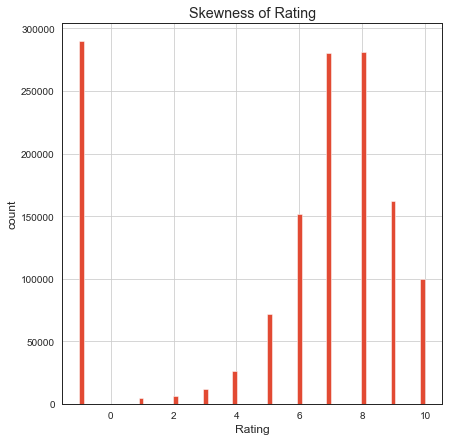

In [61]:
    # ploting the skewness
    
    plt.figure(figsize = (15, 7))
    plt.subplot(1,2,1)
    rating["rating"].hist(bins=70)
    plt.xlabel("Rating")
    plt.ylabel("count")
    plt.title("Skewness of Rating")
    plt.show()

In [63]:
# picking numeric columns
new_data=cleaned_data[['Anime_id','Title', 'ScoredBy',"Members", 'Rating']]

In [64]:
# renaming some columns
rating=rating.rename(columns={'anime_id':'Anime_id'})

In [65]:
# merging the dataframes
new_data=pd.merge(new_data,rating,on='Anime_id')

In [66]:
new_data=new_data.sort_values(by='ScoredBy', ascending=False).query('Members>500')

In [67]:
new_data=new_data.sort_values(by='ScoredBy', ascending=False).query('Members>500')

In [68]:
new_data.shape

(1206012, 7)

In [69]:
total=new_data.isnull().sum().sort_values(ascending=False)
percent=(new_data.isnull().sum()/new_data.isnull().count()).sort_values(ascending=False)
print(percent)

Title       0.000002
Anime_id    0.000000
ScoredBy    0.000000
Members     0.000000
Rating      0.000000
user_id     0.000000
rating      0.000000
dtype: float64


### Pivot Table

In [70]:
anime_pivot=new_data.pivot_table(index='Title',columns='user_id',values='rating').fillna(0)

In [71]:
anime_pivot.head()

user_id,17,54,201,226,271,294,342,392,446,478,661,741,771,786,804,917,940,958,1019,1103,1145,1176,1191,1287,1338,1344,1456,1497,1504,1522,1530,1579,1720,1822,1870,1984,2200,2243,2264,2273,2297,2378,2632,2695,2701,2810,2820,2864,2951,3009,3040,3117,3124,3127,3193,3203,3325,3338,3391,3476,3500,3557,3569,3573,3597,3615,3657,3695,4064,4102,4168,4177,4215,4350,4468,4512,4749,4759,4814,4834,4842,4843,4883,4948,4979,4987,4988,5053,5056,5073,5076,5137,5148,5244,5249,5264,5296,5310,5311,5325,5335,5357,5374,5394,5421,5428,5492,5504,5516,5526,5555,5562,5584,5598,5655,5669,5672,5680,5705,5720,5732,5770,5815,5831,5838,5886,5895,5899,5908,5950,5954,6014,6111,6118,6125,6152,6162,6164,6237,6265,6268,6321,6361,6381,6384,6392,6417,6434,6469,6474,6509,6525,6542,6569,6583,6589,6618,6695,6769,6770,6771,6773,6814,6836,6869,6893,6922,6925,6932,6969,6971,7080,7081,7114,7172,7247,7249,7297,7311,7340,7345,7350,7366,7421,7440,7446,7458,7511,7520,7533,7600,7622,7648,7659,7669,7670,7672,7674,7711,7715,7716,7726,7728,7755,7777,7802,7821,7824,7852,7896,7904,7988,8006,8031,8058,8087,8093,8094,8095,8103,8107,8115,8122,8128,8144,8149,8200,8215,8217,8221,8226,8231,8287,8308,8421,8425,8446,8494,8820,9032,9752,9995,10072,10146,10194,10231,10240,10283,10297,10298,...,60352,60365,60375,60390,60407,60440,60524,60537,60590,60675,60711,60721,60743,60791,60798,60917,60918,60932,60975,60978,60985,60986,61007,61024,61060,61065,61110,61130,61149,61163,61188,61189,61210,61254,61329,61338,61344,61349,61368,61389,61409,61443,61484,61488,61504,61529,61547,61561,61622,61651,61678,61682,61767,61831,61842,61932,62082,62209,62237,62266,62309,62469,62480,62681,62830,63121,63157,63202,63710,64126,64174,64242,64354,64372,64542,64623,64636,64664,65108,65152,65175,65237,65276,65287,65382,65420,65468,65557,65588,65595,65682,65723,65728,65755,65809,65836,65840,65844,65855,65856,65875,65944,65993,66004,66021,66024,66049,66087,66105,66118,66133,66142,66355,66390,66449,66492,66510,66551,66561,66563,66569,66650,66700,66731,66742,66755,66816,66863,66885,66989,67006,67043,67050,67082,67099,67117,67214,67239,67244,67286,67296,67348,67372,67378,67386,67451,67478,67487,67493,67509,67566,67627,67629,67635,67661,67666,67671,67701,67708,67725,67749,67762,67844,67852,67866,67871,67910,67946,67975,67981,68017,68084,68091,68148,68171,68203,68243,68465,68473,68522,68559,68633,68721,68725,68762,68787,68795,68797,68925,68939,69037,69076,69121,69341,69394,69514,69596,69964,70015,70053,70161,70201,70433,70507,70585,70725,70953,71057,71278,71284,71302,71362,71456,71491,71537,71610,71655,71790,71792,71804,71893,72054,72060,72200,72646,72794,72814,72851,72936,72997,73075,73114,73128,73132,73135,73159,73162,73177,73188,73234,73272,73286,73340,73356,73362,73378,73395,73408,73499,73502
Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Reccomendation System - Collaborative Filtering

### 1.Item Based

In [74]:
# importing the libraries
from scipy.sparse import csr_matrix

anime_matrix = csr_matrix(anime_pivot.values)

from sklearn.neighbors import NearestNeighbors

# initializing a base model
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [76]:
import numpy as np
query_index = np.random.choice(anime_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

5800


In [77]:
# creating a recommendation function
def get_rec(name,it):
    distances, indices = model_knn.kneighbors(anime_pivot.loc[name].values.reshape(1, -1), n_neighbors = 250+it)
    d1=pd.DataFrame(columns=cleaned_data.columns)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for',name)
        else:
            d2=cleaned_data.loc[cleaned_data["Title"]==anime_pivot.index[indices.flatten()[i]]]
            d1=d1.append(d2)
    return d1[["Title","ScoredBy"]].sort_values(by="ScoredBy",ascending=False)[:it]

In [78]:
get_rec('Shingeki no Kyojin',15)

Recommendations for Shingeki no Kyojin


,Title,ScoredBy
1239,Death Note,1006242.0
5682,Sword Art Online,913806.0
3567,Fullmetal Alchemist Brotherhood,730784.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
10,Naruto,645672.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0
5435,Mirai Nikki,591121.0


In [79]:
get_rec('Fullmetal Alchemist Brotherhood',15)

Recommendations for Fullmetal Alchemist Brotherhood


,Title,ScoredBy
1239,Death Note,1006242.0
6232,Shingeki no Kyojin,936784.0
5682,Sword Art Online,913806.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
10,Naruto,645672.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0
5435,Mirai Nikki,591121.0


In [80]:
get_rec('Doraemon Movie 07 Nobita to Tetsujin Heidan',10)

Recommendations for Doraemon Movie 07 Nobita to Tetsujin Heidan


,Title,ScoredBy
9863,Dungeon ni Deai wo Motomeru no wa Machigatteir...,29421.0
2005,Digimon Adventure Bokura no War Game,29173.0
667,Digimon Savers,28566.0
1356,Bakuten Shoot Beyblade 2002,22666.0
2006,Digimon Adventure 02 Diablomon no Gyakushuu,21737.0
898,Medarot,21122.0
2447,Digimon Adventure 02 Movies,18619.0
1355,Bakuten Shoot Beyblade G Revolution,17211.0
9306,To LOVERu Darkness 2nd OVA,16698.0
1993,One Piece Jango no Dance Carnival,14493.0


In [81]:
get_rec('Naruto',10)

Recommendations for Naruto


,Title,ScoredBy
1239,Death Note,1006242.0
6232,Shingeki no Kyojin,936784.0
5682,Sword Art Online,913806.0
3567,Fullmetal Alchemist Brotherhood,730784.0
8859,One Punch Man,687965.0
7300,Tokyo Ghoul,656039.0
4121,Angel Beats,640177.0
1274,Code Geass Hangyaku no Lelouch,625466.0
6891,No Game No Life,620456.0
5435,Mirai Nikki,591121.0


In [82]:
import pickle
filename='KNN_model_forCF.sav'
pickle.dump(model_knn,open(filename,'wb'))

### 2. User Based

In [83]:
new_data=new_data.rename(columns={'rating':'user_rating'})

In [84]:
rat=new_data[["user_id","Anime_id","user_rating"]]
rat

,user_id,Anime_id,user_rating
279208,6474,1535,8
279475,21211,1535,7
279518,22706,1535,8
279517,22642,1535,8
279516,22613,1535,9
...,...,...,...
1157546,32687,30512,-1
1157544,342,30512,-1
1157545,1530,30512,5
1112340,48766,27943,-1


In [85]:
unique_users = {int(x): i for i,x in enumerate(rat.user_id.unique())}
unique_items = {int(x): i for i,x in enumerate(rat.Anime_id.unique())}

In [86]:
anime_collabolative_filter = np.zeros((len(unique_items), len(unique_users)))

for user_id, anime_id, user_rating in rat.values:
    try:
        anime_collabolative_filter[unique_items[anime_id], unique_users[user_id]] = user_rating
    except KeyError:
        continue

In [87]:
anime_collabolative_filter=anime_collabolative_filter.T

In [88]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(anime_collabolative_filter, metric='cosine')

In [89]:
user_similarity.shape

(1853, 1853)

The next step is to make predictions based on these similarities. The prediction Pu,i is given by: Here, title

  * Pu,i is the prediction of an item.
  * Rv,i is the rating given by a user v to a movie i.
  * Su,v is the similarity between users.
  
Let’s define a function to do just that.

In [90]:
# prediction function
def predict(ratings, similarity, type):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

In [91]:
user_prediction = predict(anime_collabolative_filter, user_similarity, type='user')

In [92]:
user_prediction.shape

(1853, 7124)

In [93]:
user_prediction


array([[5.38843613, 4.94957335, 4.93162093, ..., 0.24757566, 0.24565556,
        0.24615819],
       [5.53183677, 5.07627818, 5.06290727, ..., 0.26057215, 0.25862597,
        0.25904476],
       [5.47990467, 5.12318424, 5.17845036, ..., 0.09151078, 0.08963924,
        0.0900345 ],
       ...,
       [5.80990357, 5.50065958, 5.56223257, ..., 0.14561976, 0.14328321,
        0.14359826],
       [5.97101053, 5.62312104, 5.68897577, ..., 0.18109557, 0.17871755,
        0.17898294],
       [6.03079301, 5.62952127, 5.6842946 , ..., 0.16192675, 0.15958053,
        0.15974762]])

In [94]:
inv_map = {v: k for k, v in unique_items.items()}

In [95]:
inv_map

{0: 1535,
 1: 16498,
 2: 11757,
 3: 5114,
 4: 30276,
 5: 22319,
 6: 20,
 7: 6547,
 8: 1575,
 9: 19815,
 10: 10620,
 11: 9253,
 12: 4224,
 13: 2904,
 14: 21881,
 15: 9919,
 16: 226,
 17: 20507,
 18: 199,
 19: 121,
 20: 31964,
 21: 22199,
 22: 32281,
 23: 27899,
 24: 2001,
 25: 31043,
 26: 31240,
 27: 269,
 28: 6702,
 29: 2167,
 30: 3588,
 31: 23273,
 32: 18679,
 33: 22535,
 34: 11061,
 35: 9989,
 36: 15809,
 37: 23755,
 38: 9756,
 39: 6746,
 40: 10087,
 41: 11617,
 42: 28223,
 43: 6880,
 44: 1,
 45: 30,
 46: 4181,
 47: 30831,
 48: 28171,
 49: 5081,
 50: 28121,
 51: 10793,
 52: 853,
 53: 431,
 54: 164,
 55: 30503,
 56: 14741,
 57: 7054,
 58: 28999,
 59: 11741,
 60: 24833,
 61: 205,
 62: 4898,
 63: 17265,
 64: 28851,
 65: 11771,
 66: 18897,
 67: 223,
 68: 2025,
 69: 23283,
 70: 5680,
 71: 14227,
 72: 1689,
 73: 20583,
 74: 356,
 75: 14345,
 76: 26243,
 77: 1195,
 78: 29803,
 79: 32182,
 80: 523,
 81: 18153,
 82: 20787,
 83: 15451,
 84: 22297,
 85: 10719,
 86: 2236,
 87: 15583,
 88: 8769,


In [96]:
# predictor
def finding_anime_for_user(user,it, ratings=anime_collabolative_filter, preds=user_prediction):
    recos = {'Anime_id': [],'rating': []}
    user_array = preds[user]
    orig_rat = ratings[user]
    for each in range(0,len(orig_rat)):
        if orig_rat[each] == 0: #ensure only non-rated gets appended
            recos['Anime_id'].append(inv_map[each])
            recos['rating'].append(user_array[each])
    recos_df = pd.DataFrame(recos)
    #print(recos_df)
    #for i in (0,len(recos_df)):
        #print(recos_df["anime_id"][i])
        #recos_df["anime_id"][i]=inv_map[recos_df["anime_id"][i]]
    final_recos_df = pd.merge(recos_df, cleaned_data,
                              how='left', on='Anime_id')
    return final_recos_df.sort_values(by='rating',ascending=False)[["Title","ScoredBy","Members","rating"]].dropna(subset=["Title"]).head(it)

In [97]:
finding_anime_for_user(2,250).sort_values(by="ScoredBy",ascending=False).head(15)

,Title,ScoredBy,Members,rating
0,Shingeki no Kyojin,936784.0,1340641.0,5.123184
1,One Punch Man,687965.0,1015163.0,4.232126
2,Tokyo Ghoul,656039.0,1008192.0,3.620089
3,No Game No Life,620456.0,966110.0,4.899550
4,Sword Art Online II,528708.0,827221.0,3.608167
5,Noragami,499984.0,842558.0,3.977427
6,Boku no Hero Academia,489625.0,757460.0,2.502812
7,Akame ga Kill,473471.0,773994.0,3.329702
9,Tokyo Ghoul A,450390.0,679126.0,2.634912
10,Boku dake ga Inai Machi,438462.0,696118.0,3.440175


In [98]:
test=finding_anime_for_user(15,100)

In [99]:
test.head()

,Title,ScoredBy,Members,rating
10,Toki wo Kakeru Shoujo,248870.0,410159.0,4.918012
19,Great Teacher Onizuka,186958.0,359917.0,4.735559
18,NHK ni Youkoso,188728.0,383024.0,4.644401
5,Ouran Koukou Host Club,334681.0,538057.0,4.562272
11,Accel World,235678.0,432566.0,4.546223


In [100]:
import sklearn
import math

In [101]:
test.fillna(0)

,Title,ScoredBy,Members,rating
10,Toki wo Kakeru Shoujo,248870.0,410159.0,4.918012
19,Great Teacher Onizuka,186958.0,359917.0,4.735559
18,NHK ni Youkoso,188728.0,383024.0,4.644401
5,Ouran Koukou Host Club,334681.0,538057.0,4.562272
11,Accel World,235678.0,432566.0,4.546223
...,...,...,...,...
114,ZombieLoan,50057.0,106397.0,2.828694
16,Haikyuu Second Season,204532.0,332116.0,2.823051
226,Mitsudomoe,29951.0,69498.0,2.816034
9,Mob Psycho 100,271163.0,482035.0,2.807497


In [102]:
mse=sklearn.metrics.mean_squared_error(test.ScoredBy, test.rating)

In [103]:
print("MSE:",mse / 10000000000)

MSE: 2.1998279013777156


In [104]:
rmse = math.sqrt(mse)

In [105]:
print("RMSE:",rmse / 100000)

RMSE: 1.4831816818507826


In [106]:
np.save("CF_data_matrix.npy", anime_collabolative_filter)

In [107]:
np.save("user_prediction.npy",user_prediction)

# HYBRID RECOMMENDATION 

In [108]:
data = pd.read_csv('Anime_data.csv')
data.head()

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001",https://myanimelist.net/anime/5/Cowboy_Bebop__...
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998",https://myanimelist.net/anime/6/Trigun
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002",https://myanimelist.net/anime/7/Witch_Hunter_R...
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005",https://myanimelist.net/anime/8/Bouken_Ou_Beet


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17002 entries, 0 to 17001
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Anime_id    17002 non-null  int64  
 1   Title       17002 non-null  object 
 2   Genre       14990 non-null  object 
 3   Synopsis    15583 non-null  object 
 4   Type        16368 non-null  object 
 5   Producer    7635 non-null   object 
 6   Studio      7919 non-null   object 
 7   Rating      14425 non-null  float64
 8   ScoredBy    13227 non-null  float64
 9   Popularity  16368 non-null  float64
 10  Members     17002 non-null  float64
 11  Episodes    14085 non-null  float64
 12  Source      15075 non-null  object 
 13  Aired       16368 non-null  object 
 14  Link        16368 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 1.9+ MB


In [110]:
data.isna().sum()

Anime_id         0
Title            0
Genre         2012
Synopsis      1419
Type           634
Producer      9367
Studio        9083
Rating        2577
ScoredBy      3775
Popularity     634
Members          0
Episodes      2917
Source        1927
Aired          634
Link           634
dtype: int64

In [111]:
data.shape

(17002, 15)

In [112]:
data['Anime_id'].value_counts().unique()

array([2, 1], dtype=int64)

In [113]:
data.describe()

,Anime_id,Rating,ScoredBy,Popularity,Members,Episodes
count,17002.000000,14425.000000,1.322700e+04,16368.000000,1.700200e+04,14085.000000
mean,20446.579638,6.287867,1.139084e+04,8131.919599,2.038130e+04,11.482712
std,14342.513259,1.141401,4.328434e+04,4714.683351,7.121404e+04,44.089040
min,1.000000,1.000000,1.000000e+00,1.000000,0.000000e+00,1.000000
25%,5581.500000,5.620000,4.300000e+01,4042.500000,1.450000e+02,1.000000
50%,21334.000000,6.410000,4.780000e+02,8115.000000,1.113000e+03,1.000000
75%,34789.250000,7.090000,3.831000e+03,12208.250000,7.855750e+03,12.000000
max,40960.000000,10.000000,1.006242e+06,16338.000000,1.451708e+06,1818.000000


In [114]:
data['Anime_id'].duplicated().sum()

152

In [115]:
data['Type'].unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', 'Unknown', nan],
      dtype=object)

We will create a function that will be used to clean the anime titles using REGEX.

In [116]:
# Function for cleaning the anime titles with REGEX
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [117]:
# applying the function on the title column
data["Title"] = data["Title"].apply(clean_title)
data

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001",https://myanimelist.net/anime/5/Cowboy_Bebop__...
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998",https://myanimelist.net/anime/6/Trigun
3,7,Witch Hunter Robin,"['Action', 'Magic', 'Police', 'Supernatural', ...",Witches are individuals with special powers li...,TV,['Bandai Visual'],['Sunrise'],7.34,31875.0,1278.0,74889.0,26.0,Original,"Jul 2, 2002 to Dec 24, 2002",https://myanimelist.net/anime/7/Witch_Hunter_R...
4,8,Bouken Ou Beet,"['Adventure', 'Fantasy', 'Shounen', 'Supernatu...",It is the dark century and the people are suff...,TV,NaN,['Toei Animation'],7.04,4757.0,3968.0,11247.0,52.0,Manga,"Sep 30, 2004 to Sep 29, 2005",https://myanimelist.net/anime/8/Bouken_Ou_Beet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16997,27499,Sore Ike Anpanman Anpanman to Kaizoku Lobster,NaN,NaN,Special,NaN,NaN,5.50,NaN,NaN,70.0,NaN,NaN,NaN,NaN
16998,12091,X Bomber,NaN,NaN,TV,NaN,NaN,5.94,NaN,NaN,199.0,NaN,NaN,NaN,NaN
16999,29133,X Bomber Pilot,NaN,NaN,Special,NaN,NaN,4.28,NaN,NaN,77.0,NaN,NaN,NaN,NaN
17000,34485,Gankochan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN


We will then use a Term frequency - inverse document frequency to create a search engine so that it is easy to find an anime title and its anime id. The tfdif will enable the computer to find the title that is most similar to the title that we will enter.

In [118]:
# vector matrix for the anime titles

from sklearn.feature_extraction.text import TfidfVectorizer

# finding groups of 2 words that are consecutive
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(data["Title"])

We will then create a function that will use cosine similarity to compute the similarity between a term that we will enter in our search box and all the anime titles in our dataset.

In [119]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# creating a search function 
def search(title):
    """
    A function that takes in a search term of the title that we are 
    looking for then cleans it and uses the vectorizer
    to turn it into a sparse matrix and then uses cosine similarity to find the
    most similar titles.
    """
    # cleaning the title entered
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()

    # find the 5 most similar titles to the searcch term
    indices = np.argpartition(similarity, -5)[-5:]

    # reverse results so that most similar result is at the top
    results = data.iloc[indices].iloc[::-1]
    
    return results

We will then build an interactive search box using our function above. The search box will enable one to type in the name of an anime and see the results.

In [120]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    # setting default value as Trigun
    value='Trigun',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]

        # display output when length of title is more than 5
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='Trigun', description='Movie Title:')

Output()

We will hardcode an anime id for the 'Cowoy Bebop' anime to find the users who watched and also liked same anime and gave it a rating greater than 6.

In [121]:
# hard coding an anime id to find the users who liked the same movie
movie_id = 1

#def find_similar_movies(movie_id):
anime = data[data["Anime_id"] == movie_id]

We  will now use the ratings dataset to find the users who liked the same movie.

In [122]:
ratings = pd.read_csv('rating.csv')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [123]:
# finding similar users
similar_users = ratings[(ratings["anime_id"] == movie_id) & (ratings["rating"] > 6)]["user_id"].unique()
similar_users

array([   19,    21,    23, ..., 73507, 73513, 73515], dtype=int64)

We will then create a put it into a dataframe to return the records of the similar users.

In [124]:

similar_user_recs = ratings[(ratings["user_id"].isin(similar_users)) & (ratings["rating"] > 6)]
similar_user_recs

,user_id,anime_id,rating
2240,19,1,10
2241,19,5,9
2242,19,121,8
2243,19,199,9
2244,19,578,10
...,...,...,...
7813730,73515,13659,8
7813731,73515,14345,7
7813732,73515,16512,7
7813733,73515,17187,9


In [125]:
# getting the anime ids from the dataframe

similar_user_recs = ratings[(ratings["user_id"].isin(similar_users)) & (ratings["rating"] > 6)]["anime_id"]
similar_user_recs

2240           1
2241           5
2242         121
2243         199
2244         578
           ...  
7813730    13659
7813731    14345
7813732    16512
7813733    17187
7813734    22145
Name: anime_id, Length: 1809323, dtype: int64

We will then narrow down the dataframe so that we only get 10% or more of users who are similar and also liked the same movie

In [126]:
# get value counts for the movie ids
similar_user_recs.value_counts()

1        12940
1535      8315
1575      7235
121       7011
2001      6785
         ...  
3922         1
4834         1
5393         1
7155         1
11523        1
Name: anime_id, Length: 8239, dtype: int64

In [127]:
# Converting to percentage
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

# Taking records where only greater than 10% liked
similar_user_recs = similar_user_recs[similar_user_recs > .10]
similar_user_recs

1        1.000000
1535     0.642581
1575     0.559119
121      0.541808
2001     0.524343
           ...   
3002     0.101391
486      0.101159
239      0.100773
357      0.100696
15451    0.100077
Name: anime_id, Length: 326, dtype: float64

We now have a set of 326 animes where more than 10% of users liked the anime title. We will now find users who liked animes that are similar to the 'Cowboy' anime. This will be done by finding the users who have rated the animes in our 'similar_user_recs'.

In [128]:
# finding how much all users in the dataset like the animes
all_users = ratings[(ratings["anime_id"].isin(similar_user_recs.index)) & (ratings["rating"] > 6)]
all_users

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813723,73515,12413,9
7813730,73515,13659,8
7813731,73515,14345,7
7813735,73516,790,9


We will then find the percentage of all users who recommended the animes that are in ``similar_user_recs``.

In [129]:
# calculating percentage
all_user_recs = all_users["anime_id"].value_counts() / len(all_users["user_id"].unique())
all_user_recs

1535     0.481432
16498    0.353069
1575     0.343044
11757    0.329717
6547     0.322566
           ...   
166      0.034704
486      0.030753
239      0.030679
617      0.030473
329      0.028866
Name: anime_id, Length: 326, dtype: float64

We will then compare the percentages in ```similar_user_recs``` and ```all_users_recs``` by joining the two pandas series so as to see how users similar to us liked the anime and how much an average person liked the same animes.

The goal is to find the animes that have a big difference.

In [130]:
# joining the two pandas series
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages

,similar,all
1,1.000000,0.190768
1535,0.642581,0.481432
1575,0.559119,0.343044
121,0.541808,0.295956
2001,0.524343,0.240819
...,...,...
3002,0.101391,0.036886
486,0.101159,0.030753
239,0.100773,0.030679
357,0.100696,0.053825


We will then calculate a score by dividing one percentage by the other.

In [131]:
# finding the ratio between the percentages
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]

# sorting the recommendations based on the scores
rec_percentages = rec_percentages.sort_values("score", ascending=False)
rec_percentages

,similar,all,score
1,1.000000,0.190768,5.241963
5,0.382767,0.081025,4.724062
400,0.142040,0.035721,3.976363
329,0.106105,0.028866,3.675799
801,0.184158,0.050125,3.673999
...,...,...,...
11757,0.339335,0.329717,1.029173
15451,0.100077,0.098170,1.019424
11617,0.147991,0.147484,1.003435
7054,0.165688,0.174109,0.951632


From the above dataframe, the higher the score, the better the recommendation.

We will then get the top 10 recommendations and merge that with our ```anime``` dataset so as to get the title of the movies.

In [132]:
# getting top 10 recommendations
rec_percentages.head(10).merge(data, left_index=True, right_on="Anime_id")

,similar,all,score,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1.000000,0.190768,5.241963,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop
1,0.382767,0.081025,4.724062,5,Cowboy Bebop Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001",https://myanimelist.net/anime/5/Cowboy_Bebop__...
15087,0.142040,0.035721,3.976363,400,Seihou Bukyou Outlaw Star,NaN,Gene Starwind has always dreamed of piloting h...,TV,NaN,NaN,7.98,NaN,1016.0,109861.0,NaN,NaN,"Jan 9, 1998 to Jun 26, 1998",https://myanimelist.net/anime/400/Seihou_Bukyo...
301,0.106105,0.028866,3.675799,329,Planetes,"['Drama', 'Romance', 'Sci-Fi', 'Seinen', 'Space']","In 2075, space travel is no longer just a drea...",TV,"['Bandai Visual', 'NHK']",['Sunrise'],8.36,46131.0,656.0,138203.0,26.0,Manga,"Oct 4, 2003 to Apr 17, 2004",https://myanimelist.net/anime/329/Planetes
653,0.184158,0.050125,3.673999,801,Koukaku Kidoutai Stand Alone Complex 2nd GIG,"['Action', 'Military', 'Sci-Fi', 'Mystery', 'P...","Following the closure of the ""Laughing Man"" ca...",TV,"['Bandai Visual', 'Dentsu', 'Victor Entertainm...",['Production I.G'],8.55,72115.0,626.0,149102.0,26.0,Manga,"Jan 1, 2004 to Jan 8, 2005",https://myanimelist.net/anime/801/Koukaku_Kido...
3226,0.125502,0.035426,3.542633,4106,Trigun Badlands Rumble,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...",20 years after meddling into the bank heist o...,Movie,"['flying DOG', 'Sunny Side Up', 'Studio Jack',...",['Madhouse'],8.05,46942.0,1117.0,84011.0,1.0,Manga,"Apr 2, 2010",https://myanimelist.net/anime/4106/Trigun__Bad...
406,0.263756,0.074877,3.522508,467,Koukaku Kidoutai Stand Alone Complex,"['Action', 'Military', 'Sci-Fi', 'Police', 'Me...","In the not so distant future, mankind has adva...",TV,"['Bandai Visual', 'Dentsu', 'Victor Entertainm...",['Production I.G'],8.46,110151.0,331.0,251675.0,26.0,Manga,"Oct 1, 2002 to Oct 1, 2003",https://myanimelist.net/anime/467/Koukaku_Kido...
527,0.106337,0.030473,3.489570,617,Juubee Ninpuuchou,"['Adventure', 'Historical', 'Horror', 'Superna...",Jubei Kibagami wanders feudal Japan as an itin...,Movie,['Movic'],['Madhouse'],7.66,40341.0,1260.0,70788.0,1.0,Original,"Jun 5, 1993",https://myanimelist.net/anime/617/Juubee_Ninpu...
15078,0.150850,0.043741,3.448706,468,Koukaku Kidoutai 2 Innocence,NaN,"With Major Motoko Kusanagi missing, Section 9'...",Movie,NaN,NaN,7.93,NaN,929.0,121133.0,NaN,NaN,"Mar 6, 2004",https://myanimelist.net/anime/468/Koukaku_Kido...
244,0.128130,0.037402,3.425768,267,Gungrave,"['Action', 'Drama', 'Sci-Fi', 'Seinen', 'Super...","Brandon Heat and Harry MacDowel, two friends s...",TV,['Tohokushinsha Film Corporation'],['Madhouse'],7.94,47119.0,812.0,118089.0,26.0,Game,"Oct 7, 2003 to Mar 30, 2004",https://myanimelist.net/anime/267/Gungrave


We will then put all the code above into one function.

In [133]:
def find_similar_movies(movie_id):
    
    # finding recommendations for users that are similar 
    similar_users = ratings[(ratings["anime_id"] == movie_id) & (ratings["rating"] > 6)]["user_id"].unique()
    similar_user_recs = ratings[(ratings["user_id"].isin(similar_users)) & (ratings["rating"] > 6)]["anime_id"]

    # narrowing them down to 10%
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > .10]

    # finding how common the recommendations are among all users
    all_users = ratings[(ratings["anime_id"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["anime_id"].value_counts() / len(all_users["user_id"].unique())

    # concatenating all_user_recs and similar_user_recs
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    
    # calculating the score
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    # sorting values based on score
    rec_percentages = rec_percentages.sort_values("score", ascending=False)

    # return the top 10 recommendations
    return rec_percentages.head(10).merge(data, left_index=True, right_on="Anime_id")[["score", "Title", "Genre"]]

We will now create an interactive recommendation widget where one gets to type in an anime title and get recommendations based on the anime title

In [134]:
# creating an input widget
movie_name_input = widgets.Text(
    value='Trigun',
    description='Movie Title:',
    disabled=False
)

# creating an output widget
recommendation_list = widgets.Output()

# creating an ontype function
def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()

        # grab title from input widget
        title = data["new"]

        # display output when length of title is more than 5
        if len(title) > 5:
            # search title using the search function
            results = search(title)
            movie_id = results.iloc[0]["Anime_id"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)

Text(value='Trigun', description='Movie Title:')

Output()

### Deployment

 * The hybrid model was deployed through streamlit.
    
 * One can use the model through the following [Link][https://anime-deployment.streamlit.app/] 